<a href="https://colab.research.google.com/github/ASi-F/NLPlay-with-Transformers/blob/main/Bert_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT base

The BERT Transformer is available in 2 sizes- **base** and **large**. Here we train the smaller base version. It has **6 encoders** stacked on top of each other and gives an output embedding of dimension 768. Here we train the large model on a dataset of 21,000 reviews and evaluate on a dataset of 9,000 reviews by using **a Feed Forward Neural Network with 3 hidden layers and 500 neurons per layer architecture**. The output embeddings are processed by this neural network which is trained on this dataset.<br>
We have achieved an accuracy of 91.25% on the training set and 92% on the training set.<br>
Not BAD!

In [ ]:
pip install transformers

In [ ]:
pip install datasets

In [3]:
import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import random 

# Preprocessing

The dataset is mounted from drive and some basic preprocessing is done to remove html tags. The review and sentiment columns are replaced by text and label columns. Here we convert the pandas df to dataset to pytorch dataloader

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IMDB Dataset.csv')

In [5]:
def remove_tags(text):
    final = ""
    stt = True
    for char in text:
        if char == '<':
            stt = False
        if(stt):
            final = final + char
        if char == '>':
            stt = True
            final = final + ' '
    return final

df['text'] = df['review'].apply(remove_tags)

In [6]:
df = df.drop('review',axis = 1)

In [7]:
df['label'] = [ 1*(sent=='positive') for sent in df['sentiment']]

df = df.drop('sentiment', axis = 1)

In [8]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)

In [9]:
model_name = 'bert-base-uncased'

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [11]:
small_train_dataset = dataset.shuffle(seed=42).select(range(2000))
small_eval_dataset = dataset.shuffle(seed=42).select(range(2000,4000))

In [12]:
train_range = [i for i in range(0,30000) if 6>=i%10 and i%10>=0]
eval_range = [i for i in range(0,30000) if 9>=i%10 and i%10>=7]

train_dataset = dataset.select(train_range).shuffle(seed=42)
eval_dataset = dataset.select(eval_range) .shuffle(seed=42)

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=10)
eval_dataloader = DataLoader(eval_dataset, batch_size=10)

# Model

In [14]:
from transformers import AutoModel

In [15]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [16]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [17]:
class Classifier(nn.Module):
  def __init__(self,hidden_dim,output_size,model_name,enc_dim):
    super(Classifier,self).__init__()

    self.model = AutoModel.from_pretrained(model_name, num_labels=2)
  
    self.LF1 = nn.Linear(enc_dim,hidden_dim)
    self.NLF1 = nn.ReLU()

    self.LF2 = nn.Linear(hidden_dim,hidden_dim)
    self.NLF2 = nn.ReLU()

    self.LF3 = nn.Linear(hidden_dim,output_size)

  def ready_train(self):
    (self.model).train()
  
  def ready_eval(self):
    self.model.eval()

  def forward(self,x):
    out = self.model(**x)[1]

    out = self.LF1(out)
    out = self.NLF1(out)

    out = self.LF2(out)
    out = self.NLF2(out)

    out = self.LF3(out)

    return F.softmax(out,dim=1)    

# Training

In [18]:
from tqdm.auto import tqdm

def train_classifier(num_epochs,train_dataloader,optimizer,classifier, loss_function = nn.CrossEntropyLoss()):
  losses = []
  num_training_steps = num_epochs*len(train_dataloader)
  progress_bar = tqdm(range(num_training_steps))
  classifier.ready_train()
  i = 0
  avg_loss = 0.
  for epoch in range(num_epochs):
    for batch in train_dataloader:
      # forward prop
      inp = tokenizer(batch['text'],padding=True, truncation=True,max_length=512, return_tensors="pt")
      inp = inp.to(device)
      out = classifier(inp)
      pred = batch['label']
      pred = pred.to(device)
      loss = loss_function(out, pred)

      # backward prop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      losses.append(loss.item())
      progress_bar.update(1)
      if i%100 == 0  and i//100>=1:
        print(avg_loss/100)
        avg_loss = 0
      i+=1
      avg_loss = avg_loss + float(loss.item())
  return losses

In [19]:
def plot_loss(losses):
  x = [i for i in range(0,len(losses))]
  plt.plot(x,losses)
  plt.title('Loss fnction')
  plt.ylabel('Loss')
  plt.xlabel('batch index')

def smooth_loss(losses,f):
  y = [0]*len(losses)
  for i in range(0,f):
    y[i] = (sum(losses[:i+1+f]))/(i+1+f)
  for i in range(f,len(losses)-f-1):
    y[i] = (sum(losses[i-f:i+f+1]))/(2*f+1)
  for i in range(len(losses)-f-1,len(losses)):
    y[i] = (sum(losses[i-f:]))/(len(losses)-i+f)
  plot_loss(y)

In [ ]:
output_size = 2
hidden_dim = 500
enc_dim = 768

classifier_bert = Classifier(hidden_dim,output_size,model_name,enc_dim)
classifier_bert.to(device)

In [21]:
num_epochs = 3
lr = 1e-3
optimizer = optim.SGD(classifier_bert.parameters(), lr)

losses = train_classifier(num_epochs,train_dataloader,optimizer,classifier_bert)

0.6936671441793442
0.6935768067836762
0.6930458164215088
0.6926910722255707
0.6923941445350646
0.6923420518636704
0.6913972151279449
0.6911318898200989
0.6901756650209427
0.6896985125541687
0.6900694268941879
0.6886929422616959
0.6881072753667832
0.6851142513751983
0.6807167410850525
0.6742672514915466
0.6613712066411972
0.6382193613052368
0.6106221944093704
0.5718843632936478
0.5420183205604553
0.5227666771411896
0.4952074059844017
0.47776074886322023
0.4801391437649727
0.4629174843430519
0.458950774371624
0.4502840316295624
0.4577393913269043
0.43790164828300476
0.45167545825242994
0.4473431086540222
0.43345404088497164
0.4391783690452576
0.4326630085706711
0.4471753469109535
0.42948903918266296
0.4330374130606651
0.412381637096405
0.43058819979429247
0.4361604627966881
0.43229325354099274
0.44376596689224246
0.4224545779824257
0.42232943803071976
0.4179317581653595
0.4167305225133896
0.4106569290161133
0.41134979218244555
0.4131434443593025
0.425347193479538
0.41184231132268906
0.41

# plot for loss per itteration

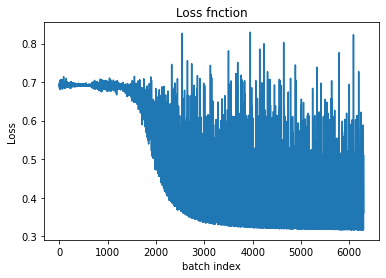

In [22]:
plot_loss(losses)

# Plot for average loss per 100 iterations

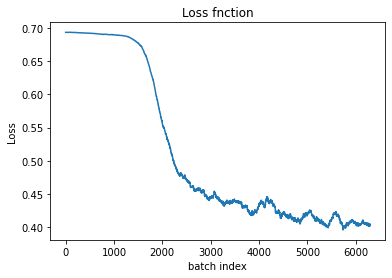

In [25]:
smooth_loss(losses,100)

In [28]:
classifier_bert.ready_eval()
def acc(dataloader,classifier):
  corr = 0
  tot = len(dataloader)*10
  for batch in dataloader:
  # forward prop
    inp = tokenizer(batch['text'],padding=True, truncation=True,max_length=512, return_tensors="pt")
    inp = inp.to(device)
    out = list(torch.argmax(classifier(inp),dim=1))
    exp = list(batch['label'])
    
    for i,x in enumerate(out):
      if x == exp[i]:
        corr = corr+1
    
  return 100*(corr/tot)

#Training set Accuracy

In [29]:
acc(train_dataloader,classifier_bert)

92.0

# Test set accuracy

In [31]:
acc(eval_dataloader,classifier_bert)

91.24444444444444